In [1]:
!pip install delu rtdl_num_embeddings

Looking in indexes: https://nexus.isb/repository/pypiorg-pypi-proxy/simple, https://nexus.isb/repository/deml-prod-pypi-hosted/simple


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import delu
from tqdm.std import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from rtdl_num_embeddings import (
    PiecewiseLinearEmbeddings,
    PeriodicEmbeddings,
)

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from functools import partial
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 500)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### === Готовим данные для модели ===

In [4]:
df = pd.read_csv('iar_hse_data.csv')
df.head()

y = df[['target']]
X = df.drop(columns=['target'])

In [6]:
cat_cols_all = X.select_dtypes(include=['object']).columns.tolist()

special = ['es_1','es_2','es_3']
cat_cols_emb = [c for c in special if c in cat_cols_all]
cat_cols  = [c for c in cat_cols_all if c not in cat_cols_emb]

X_cat = X[cat_cols].apply(LabelEncoder().fit_transform)
X_cat_emb = X[cat_cols_emb].apply(LabelEncoder().fit_transform)

X_float = X.select_dtypes(include=['float'])
X_int_float = X.select_dtypes(include=['int64']).astype(np.float32)
X_float = pd.concat([X_float, X_int_float], axis=1)
X_float = X_float.astype(np.float32)

float_features_cnt = X_float.shape[1]
cat_features_card = [X_cat[x].nunique() for x in X_cat.columns]

y = y.astype('float')

In [7]:
X_float = X_float.to_numpy()
X_cat = X_cat.to_numpy()
X_cat_emb = X_cat_emb.to_numpy()
y = y.to_numpy()
y = y[:, 0]

In [8]:
n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_idx = np.arange(0, train_end)
val_idx = np.arange(train_end, val_end)
test_idx = np.arange(val_end, n)

In [9]:
data = {
    'train' : {'x_float':X_float[train_idx], 'x_cat':X_cat[train_idx], 'x_cat_emb':X_cat_emb[train_idx], 'y':y[train_idx]},
    'val' : {'x_float':X_float[val_idx], 'x_cat':X_cat[val_idx], 'x_cat_emb':X_cat_emb[val_idx], 'y':y[val_idx]},
    'test' : {'x_float':X_float[test_idx], 'x_cat':X_cat[test_idx], 'x_cat_emb':X_cat_emb[test_idx], 'y':y[test_idx]}
}

In [10]:
preprocessing = sklearn.preprocessing.StandardScaler().fit(data['train']['x_float'])

for object in data:
    data[object]['x_float'] = preprocessing.transform(data[object]['x_float'])

In [11]:
tensors = {
    object: {k: torch.as_tensor(v, device=device) for k, v in data[object].items()} for object in data
}

### === Модель MLP с различными эмбеддингами===

In [12]:
class MLPWithSpecialEmbeddings(nn.Module):
    def __init__(
        self,
        n_num_features:int,
        n_oh_features:int,
        emb_type:str='learnable',
        d_emb:int=8,
        bins:int=16,
        lite:bool=False,
        hidden_dim:int=128,
        dropout:float=0.3
    ):
        super().__init__()
        if emb_type=='learnable':
            self.emb = nn.Embedding(
                num_embeddings=[encoders[c].classes_.size for c in cat_cols_emb][0],
                embedding_dim=d_emb
            )
            self.emb = nn.ModuleList([
                nn.Embedding(len(encoders[c].classes_), d_emb)
                for c in cat_cols_emb
            ])
            emb_out = len(cat_cols_emb)*d_emb

        elif emb_type=='piecewise':
            self.emb = PiecewiseLinearEmbeddings(
                n_bins=bins,
                d_embedding=d_emb,
                activation=False,
                version="B"
            )
            emb_out = len(cat_cols_emb)*d_emb

        elif emb_type=='periodic':
            self.emb = PeriodicEmbeddings(
                n_features=len(cat_cols_emb),
                d_embedding=d_emb,
                lite=lite
            )
            emb_out = len(cat_cols_emb)*d_emb

        else:
            raise ValueError

        mlp_in = n_num_features + n_oh_features + emb_out
        self.mlp = nn.Sequential(
            nn.Linear(mlp_in, hidden_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x_num, x_oh, x_emb):
        if isinstance(self.emb, nn.ModuleList):
            embeds = [layer(x_emb[:,i]) for i,layer in enumerate(self.emb)]
            h_emb = torch.cat(embeds, dim=1)
        else:
            h_emb = self.emb(x_emb)
            if h_emb.ndim==3: 
                h_emb = h_emb.flatten(1)
        h = torch.cat([x_num, x_oh, h_emb], dim=1)
        return self.mlp(h).squeeze(1)

In [13]:
def evaluate(model, tensors, part, batch_size=512):
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for batch in delu.iter_batches(tensors[part], batch_size):
            logits = torch.sigmoid(model(batch['x_float'], batch['x_cat']))
            y_prob.append(logits.cpu())
            y_true.append(batch['y'].cpu())
    y_prob = torch.cat(y_prob).numpy()
    y_true = torch.cat(y_true).numpy()
    y_pred = (y_prob >= 0.5).astype(int)

    return {
        'roc_auc': roc_auc_score(y_true, y_prob),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred)
    }

In [14]:
def train_model(embedding_type):
    model = MLPWithSpecialEmbeddings(
    n_num_features = X_float.shape[1],
    n_oh_features  = X_cat.shape[1],
    emb_type       = 'learnable',  
    d_emb          = 8,
    bins           = 16,
    lite           = False,
    hidden_dim     = 128,
    dropout        = 0.3,
).to(device)

    loss_fn = FocalLoss(alpha=0.25, gamma=2.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    for epoch in range(100):
        model.train()
        total_loss = 0
        for batch in delu.iter_batches(tensors['train'], 512, shuffle=True):
            optimizer.zero_grad()
            out = model(batch['x_float'], batch['x_cat'])
            loss = loss_fn(out, batch['y'])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_metrics = evaluate(model, tensors, 'val')
        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Val ROC AUC: {val_metrics['roc_auc']:.4f} | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f}")

    return model

### ***** MLP base embeddings *****

In [17]:
model = train_model('learnable')

Epoch 1 | Loss: 8.6271 | Val ROC AUC: 0.7764 | Precision: 0.5634 | Recall: 0.0574
Epoch 2 | Loss: 8.2506 | Val ROC AUC: 0.7819 | Precision: 0.6299 | Recall: 0.0336
Epoch 3 | Loss: 8.1878 | Val ROC AUC: 0.7839 | Precision: 0.6004 | Recall: 0.0448
Epoch 4 | Loss: 8.1515 | Val ROC AUC: 0.7855 | Precision: 0.5976 | Recall: 0.0629
Epoch 5 | Loss: 8.1136 | Val ROC AUC: 0.7868 | Precision: 0.6007 | Recall: 0.0798
Epoch 6 | Loss: 8.1094 | Val ROC AUC: 0.7888 | Precision: 0.6298 | Recall: 0.0762
Epoch 7 | Loss: 8.0682 | Val ROC AUC: 0.7892 | Precision: 0.5981 | Recall: 0.0904
Epoch 8 | Loss: 8.0440 | Val ROC AUC: 0.7905 | Precision: 0.6576 | Recall: 0.0771
Epoch 9 | Loss: 8.0334 | Val ROC AUC: 0.7919 | Precision: 0.6194 | Recall: 0.0864
Epoch 10 | Loss: 8.0165 | Val ROC AUC: 0.7924 | Precision: 0.6114 | Recall: 0.0993
Epoch 11 | Loss: 7.9980 | Val ROC AUC: 0.7920 | Precision: 0.5579 | Recall: 0.1267
Epoch 12 | Loss: 7.9904 | Val ROC AUC: 0.7941 | Precision: 0.6373 | Recall: 0.0888
Epoch 13 | Lo

### === Оценка трешхолда на валидации ===

In [18]:
def find_best_threshold(model, tensors, part='val'):
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(tensors[part]['x_float'], tensors[part]['x_cat'])).cpu().numpy()
    y_true = tensors[part]['y'].cpu().numpy()

    thresholds = np.linspace(0.01, 0.99, 100)
    results = []
    for t in thresholds:
        y_pred = (probs >= t).astype(int)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred)
        auc = roc_auc_score(y_true, probs)
        results.append((t, prec, rec, auc))

    best = max(results, key=lambda x: x[1])  #максимальный precision
    return {
        'best_threshold': best[0],
        'val_precision': best[1],
        'val_recall': best[2],
        'val_auc': best[3]
    }

In [19]:
thresh_info = find_best_threshold(model, tensors, part='val')
print(f"\n Лучший порог по precision на валидации: {thresh_info['best_threshold']:.2f}")
print(f"Precision: {thresh_info['val_precision']:.4f}, Recall: {thresh_info['val_recall']:.4f}, ROC AUC: {thresh_info['val_auc']:.4f}")


 Лучший порог по precision на валидации: 0.77
Precision: 1.0000, Recall: 0.0008, ROC AUC: 0.8074


### === Оценка качества на тесте с подходящим трешхолдом ===

In [20]:
def evaluate_on_test(model, tensors, threshold):
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(tensors['test']['x_float'], tensors['test']['x_cat'])).cpu().numpy()
    y_true = tensors['test']['y'].cpu().numpy()
    y_pred = (probs >= threshold).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nФинальные метрики на тесте при threshold = {threshold:.2f}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("Confusion Matrix:\n", cm)

In [21]:
evaluate_on_test(model, tensors, threshold=thresh_info['best_threshold'])


Финальные метрики на тесте при threshold = 0.77:
Precision: 1.0000
Recall:    0.0005
ROC AUC:   0.8094
Confusion Matrix:
 [[52090     0]
 [ 7906     4]]


### === График зависимости трешхолда от метрик на валидации ===

In [22]:
def plot_precision_recall_curve(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 100)
    precisions = []
    recalls = []
    f1s = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1s, label='F1-score')
    plt.xlabel('Порог вероятности')
    plt.ylabel('Значение метрики')
    plt.title('Зависимость Precision / Recall / F1 от порога')
    plt.legend()
    plt.grid(True)
    plt.show()

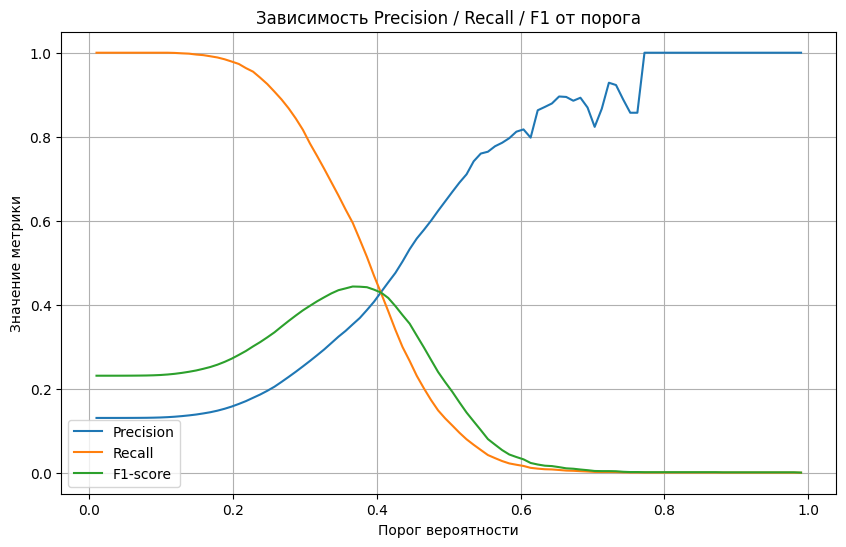

In [23]:
model.eval()
with torch.no_grad():
    val_logits = model(tensors['val']['x_float'], tensors['val']['x_cat'])
    val_proba = torch.sigmoid(val_logits).cpu().numpy()
    val_true = tensors['val']['y'].cpu().numpy()

plot_precision_recall_curve(val_true, val_proba)

###### Считаю наилучшим трешхолдом = 0.47, тк важнее немного пожертвовать precision, чтобы вырос recall, и при этом доля false positive решений не была заоблачной

### === Оценка качества на тесте с подходящим трешхолдом ===

In [24]:
evaluate_on_test(model, tensors, threshold=0.47)


Финальные метрики на тесте при threshold = 0.47:
Precision: 0.6066
Recall:    0.1989
ROC AUC:   0.8094
Confusion Matrix:
 [[51070  1020]
 [ 6337  1573]]


In [27]:
def flow_cut(y_prob, threshold):
    return (y_prob >= threshold).mean()

In [30]:
model.eval()
with torch.no_grad():
    test_proba = torch.sigmoid(model(tensors['test']['x_float'], tensors['test']['x_cat'])).cpu().numpy()
y_true = tensors['test']['y'].cpu().numpy()

In [32]:
print(f"Flow cut with best threshold: {flow_cut(test_proba, 0.47):.4f}")

Flow cut with best threshold: 0.0432


### Метрики,если срез в 4%

In [33]:
def get_threshold_for_top_percent(y_proba, top_percent=0.04):
    k = int(len(y_proba) * top_percent)
    sorted_proba = np.sort(y_proba)
    return sorted_proba[-k]

In [34]:
threshold_4pct = get_threshold_for_top_percent(test_proba, top_percent=0.04)
y_pred_top4 = (test_proba >= threshold_4pct).astype(int)

#метрики в этом срезе:
precision = precision_score(y_true, y_pred_top4)
recall = recall_score(y_true, y_pred_top4)
stream_cut = (y_pred_top4 == 1).mean()

print(f"Threshold @ top 4%: {threshold_4pct:.4f}")
print(f"Precision@4%: {precision:.4f}")
print(f"Recall@4%:    {recall:.4f}")
print(f"Отсечено:     {stream_cut*100:.2f}% заявок")

Threshold @ top 4%: 0.4741
Precision@4%: 0.6221
Recall@4%:    0.1887
Отсечено:     4.00% заявок


### === Важность фичей ===

In [35]:
def permutation_importance(model, tensors, feature_names=None, part='val'):
    model.eval()

    x_float = tensors[part]['x_float'].clone()
    x_cat = tensors[part]['x_cat'].clone()
    y_true = tensors[part]['y'].cpu().numpy()

    with torch.no_grad():
        base_preds = torch.sigmoid(model(x_float, x_cat)).cpu().numpy()
    baseline_auc = roc_auc_score(y_true, base_preds)

    importances = []
    names = []

    #перемешиваем числовые признаки
    for i in range(x_float.shape[1]):
        x_float_perm = x_float.clone()
        x_float_perm[:, i] = x_float_perm[torch.randperm(len(x_float_perm)), i]
        with torch.no_grad():
            preds = torch.sigmoid(model(x_float_perm, x_cat)).cpu().numpy()
        auc = roc_auc_score(y_true, preds)
        importances.append(baseline_auc - auc)
        if feature_names:
            names.append(feature_names['float'][i])
        else:
            names.append(f'float_{i}')

    #перемешиваем категориальные признаки
    for i in range(x_cat.shape[1]):
        x_cat_perm = x_cat.clone()
        x_cat_perm[:, i] = x_cat_perm[torch.randperm(len(x_cat_perm)), i]
        with torch.no_grad():
            preds = torch.sigmoid(model(x_float, x_cat_perm)).cpu().numpy()
        auc = roc_auc_score(y_true, preds)
        importances.append(baseline_auc - auc)
        if feature_names:
            names.append(feature_names['cat'][i])
        else:
            names.append(f'cat_{i}')

    return importances, names

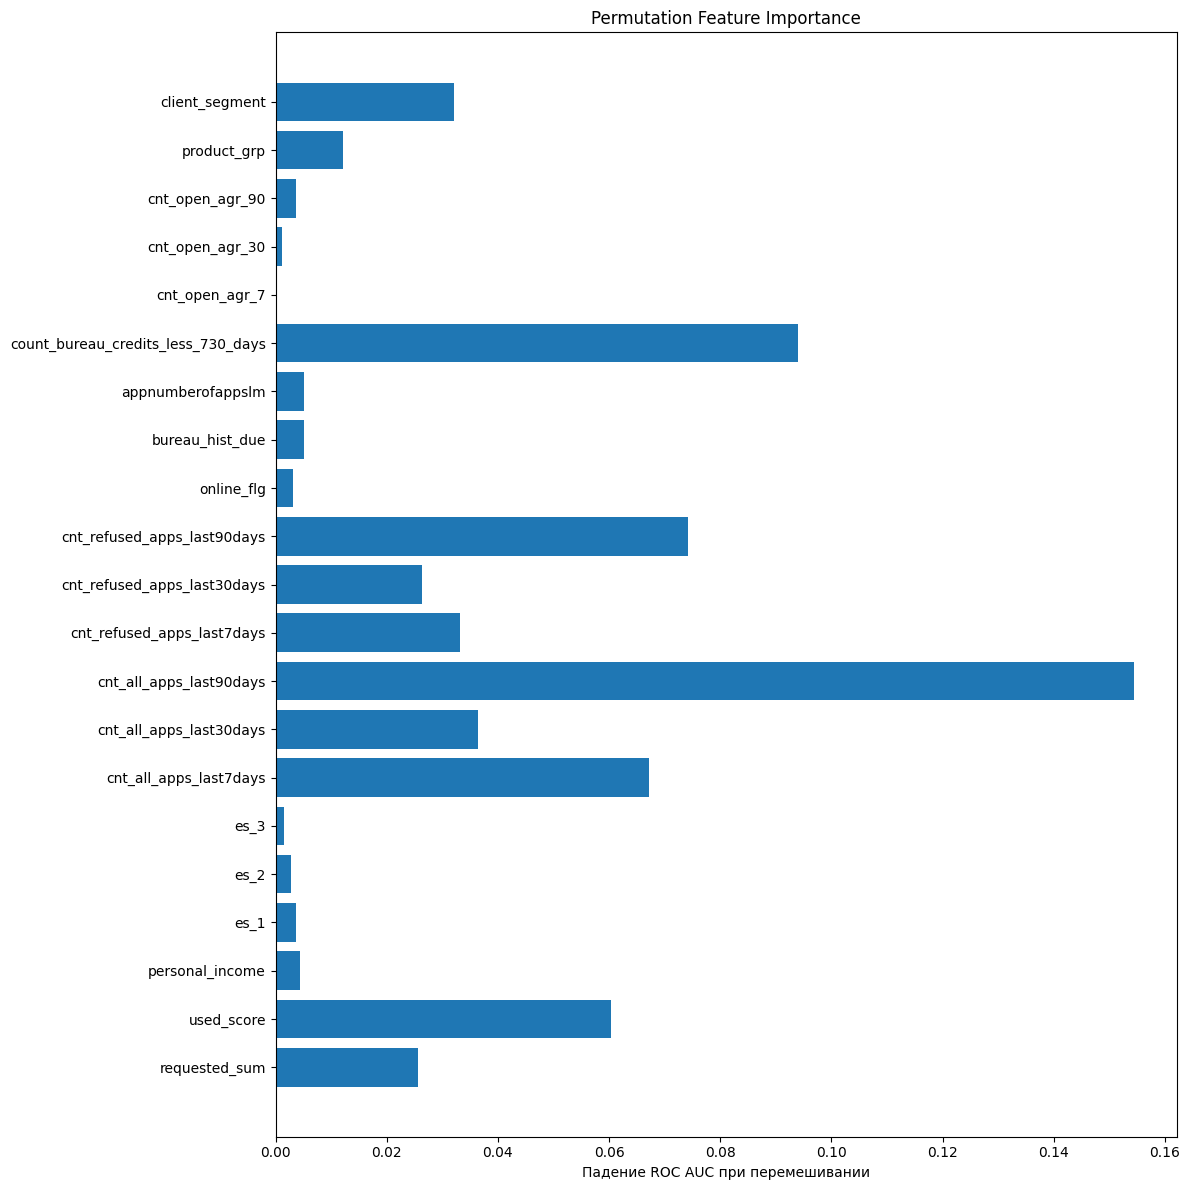

In [36]:
X_cat_df = X.select_dtypes(include=['object'])
X_float_df = X.select_dtypes(include=['float'])
X_int_float_df = X.select_dtypes(include=['int64']).astype(np.float32)
X_float_df = pd.concat([X_float_df, X_int_float_df], axis=1)

feature_names = {
    'float': list(X_float_df.columns),
    'cat': list(X_cat_df.columns),
}

importances, names = permutation_importance(model, tensors, feature_names=feature_names)

plt.figure(figsize=(12, 12))
plt.barh(names, importances)
plt.title("Permutation Feature Importance")
plt.xlabel("Падение ROC AUC при перемешивании")
plt.tight_layout()
plt.show()

### ***** MLP periodic embeddings *****

In [37]:
model = train_model('periodic')

Epoch 1 | Loss: 8.6558 | Val ROC AUC: 0.7737 | Precision: 0.5497 | Recall: 0.0679
Epoch 2 | Loss: 8.2845 | Val ROC AUC: 0.7796 | Precision: 0.5745 | Recall: 0.0731
Epoch 3 | Loss: 8.2278 | Val ROC AUC: 0.7809 | Precision: 0.5730 | Recall: 0.0819
Epoch 4 | Loss: 8.1824 | Val ROC AUC: 0.7842 | Precision: 0.5399 | Recall: 0.1208
Epoch 5 | Loss: 8.1330 | Val ROC AUC: 0.7851 | Precision: 0.5892 | Recall: 0.0926
Epoch 6 | Loss: 8.1229 | Val ROC AUC: 0.7866 | Precision: 0.6380 | Recall: 0.0626
Epoch 7 | Loss: 8.0853 | Val ROC AUC: 0.7872 | Precision: 0.5705 | Recall: 0.1018
Epoch 8 | Loss: 8.0623 | Val ROC AUC: 0.7885 | Precision: 0.6319 | Recall: 0.0676
Epoch 9 | Loss: 8.0478 | Val ROC AUC: 0.7912 | Precision: 0.5941 | Recall: 0.1036
Epoch 10 | Loss: 8.0299 | Val ROC AUC: 0.7909 | Precision: 0.6620 | Recall: 0.0674
Epoch 11 | Loss: 8.0144 | Val ROC AUC: 0.7930 | Precision: 0.6054 | Recall: 0.0998
Epoch 12 | Loss: 8.0026 | Val ROC AUC: 0.7946 | Precision: 0.6765 | Recall: 0.0586
Epoch 13 | Lo

### === Оценка трешхолда на валидации ===

In [38]:
thresh_info = find_best_threshold(model, tensors, part='val')
print(f"\n Лучший порог по precision на валидации: {thresh_info['best_threshold']:.2f}")
print(f"Precision: {thresh_info['val_precision']:.4f}, Recall: {thresh_info['val_recall']:.4f}, ROC AUC: {thresh_info['val_auc']:.4f}")


 Лучший порог по precision на валидации: 0.86
Precision: 1.0000, Recall: 0.0010, ROC AUC: 0.8022


### === Оценка качества на тесте с подходящим трешхолдом ===

In [39]:
evaluate_on_test(model, tensors, threshold=thresh_info['best_threshold'])


Финальные метрики на тесте при threshold = 0.86:
Precision: 1.0000
Recall:    0.0003
ROC AUC:   0.8050
Confusion Matrix:
 [[52090     0]
 [ 7908     2]]


### === График зависимости трешхолда от метрик на валидации ===

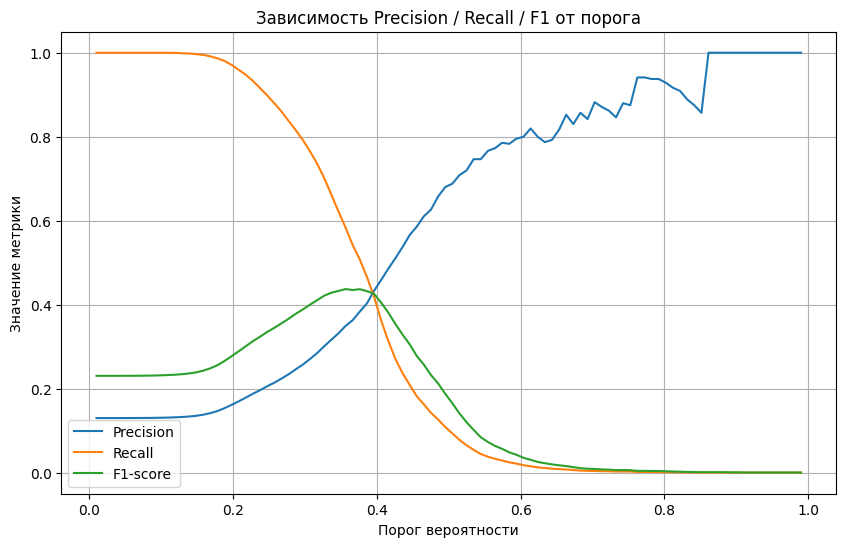

In [40]:
model.eval()
with torch.no_grad():
    val_logits = model(tensors['val']['x_float'], tensors['val']['x_cat'])
    val_proba = torch.sigmoid(val_logits).cpu().numpy()
    val_true = tensors['val']['y'].cpu().numpy()

plot_precision_recall_curve(val_true, val_proba)

###### Считаю наилучшим трешхолдом = 0.43, тк важнее немного пожертвовать precision, чтобы вырос recall, и при этом доля false positive решений не была заоблачной

### === Оценка качества на тесте с подходящим трешхолдом ===

In [41]:
evaluate_on_test(model, tensors, threshold=0.48)


Финальные метрики на тесте при threshold = 0.48:
Precision: 0.6574
Recall:    0.1458
ROC AUC:   0.8050
Confusion Matrix:
 [[51489   601]
 [ 6757  1153]]


In [42]:
model.eval()
with torch.no_grad():
    test_proba = torch.sigmoid(model(tensors['test']['x_float'], tensors['test']['x_cat'])).cpu().numpy()
y_true = tensors['test']['y'].cpu().numpy()

In [43]:
print(f"Flow cut with best threshold: {flow_cut(test_proba, 0.48):.4f}")

Flow cut with best threshold: 0.0292


#### Метрики,если срез в 4%

In [44]:
threshold_4pct = get_threshold_for_top_percent(test_proba, top_percent=0.04)
y_pred_top4 = (test_proba >= threshold_4pct).astype(int)

#метрики в этом срезе:
precision = precision_score(y_true, y_pred_top4)
recall = recall_score(y_true, y_pred_top4)
stream_cut = (y_pred_top4 == 1).mean()

print(f"Threshold @ top 4%: {threshold_4pct:.4f}")
print(f"Precision@4%: {precision:.4f}")
print(f"Recall@4%:    {recall:.4f}")
print(f"Отсечено:     {stream_cut*100:.2f}% заявок")

Threshold @ top 4%: 0.4606
Precision@4%: 0.6096
Recall@4%:    0.1850
Отсечено:     4.00% заявок


### === Важность фичей ===

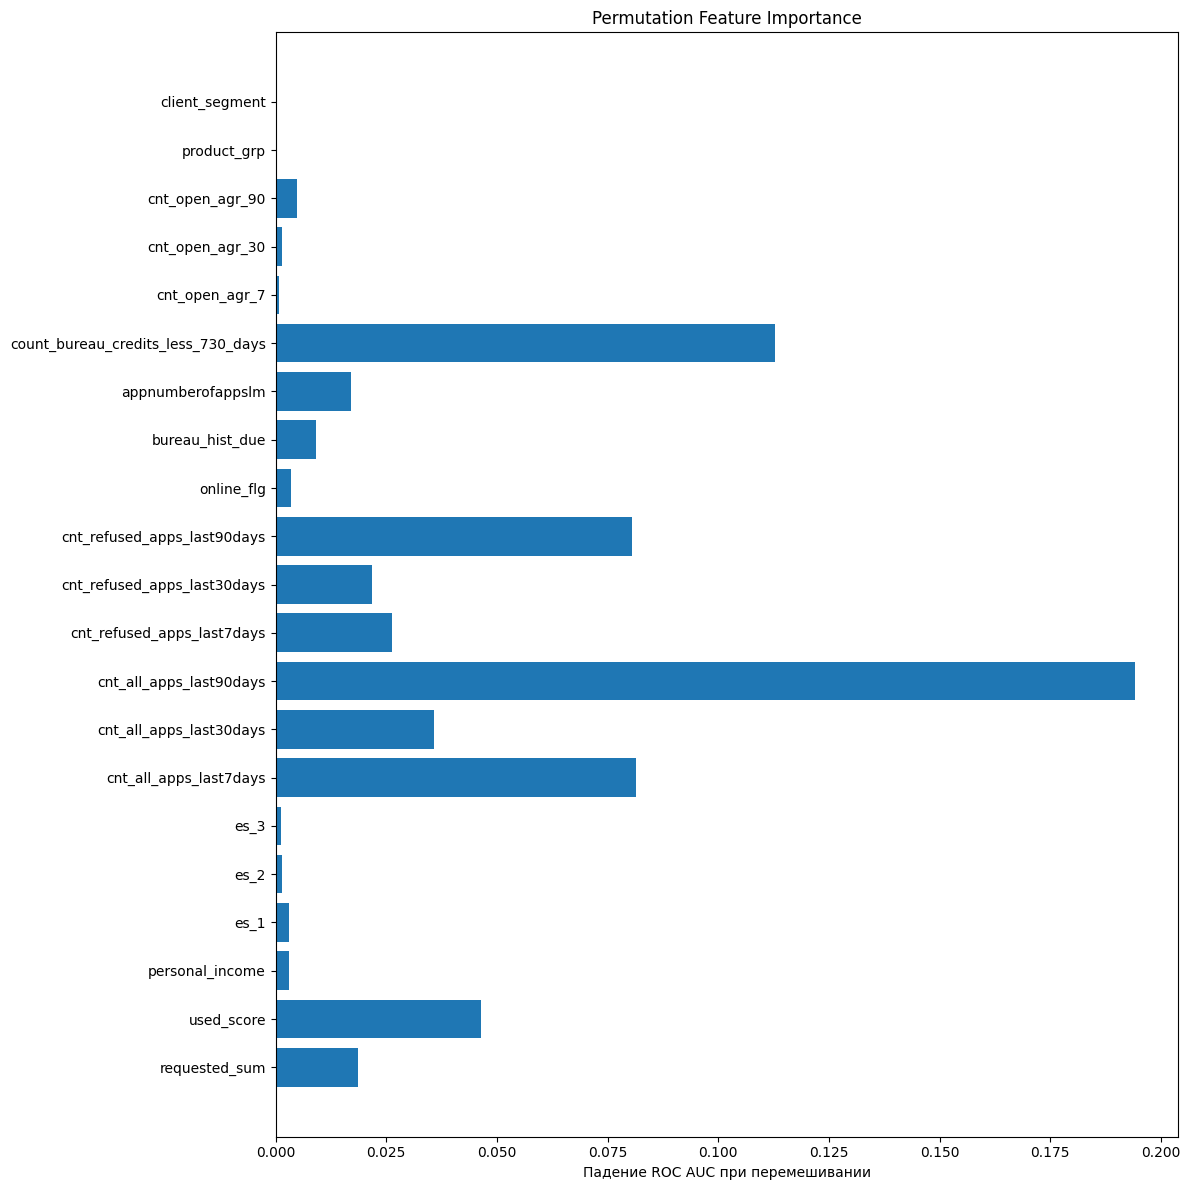

In [45]:
X_cat_df = X.select_dtypes(include=['object'])
X_float_df = X.select_dtypes(include=['float'])
X_int_float_df = X.select_dtypes(include=['int64']).astype(np.float32)
X_float_df = pd.concat([X_float_df, X_int_float_df], axis=1)

feature_names = {
    'float': list(X_float_df.columns),
    'cat': list(X_cat_df.columns),
}

importances, names = permutation_importance(model, tensors, feature_names=feature_names)

plt.figure(figsize=(12, 12))
plt.barh(names, importances)
plt.title("Permutation Feature Importance")
plt.xlabel("Падение ROC AUC при перемешивании")
plt.tight_layout()
plt.show()

### ***** MLP piecewise-linear embeddings *****

In [46]:
model = train_model('piecewise')

Epoch 1 | Loss: 8.6027 | Val ROC AUC: 0.7741 | Precision: 0.5861 | Recall: 0.0228
Epoch 2 | Loss: 8.2689 | Val ROC AUC: 0.7786 | Precision: 0.6149 | Recall: 0.0303
Epoch 3 | Loss: 8.2109 | Val ROC AUC: 0.7823 | Precision: 0.5676 | Recall: 0.1004
Epoch 4 | Loss: 8.1588 | Val ROC AUC: 0.7847 | Precision: 0.5836 | Recall: 0.0840
Epoch 5 | Loss: 8.1332 | Val ROC AUC: 0.7861 | Precision: 0.6299 | Recall: 0.0637
Epoch 6 | Loss: 8.1007 | Val ROC AUC: 0.7867 | Precision: 0.6230 | Recall: 0.0690
Epoch 7 | Loss: 8.0822 | Val ROC AUC: 0.7891 | Precision: 0.6155 | Recall: 0.0760
Epoch 8 | Loss: 8.0428 | Val ROC AUC: 0.7911 | Precision: 0.6016 | Recall: 0.0934
Epoch 9 | Loss: 8.0287 | Val ROC AUC: 0.7919 | Precision: 0.6486 | Recall: 0.0727
Epoch 10 | Loss: 8.0111 | Val ROC AUC: 0.7930 | Precision: 0.6236 | Recall: 0.0861
Epoch 11 | Loss: 7.9901 | Val ROC AUC: 0.7940 | Precision: 0.6507 | Recall: 0.0778
Epoch 12 | Loss: 7.9644 | Val ROC AUC: 0.7959 | Precision: 0.6025 | Recall: 0.1068
Epoch 13 | Lo

### === Оценка трешхолда на валидации ===

In [47]:
thresh_info = find_best_threshold(model, tensors, part='val')
print(f"\n Лучший порог по precision на валидации: {thresh_info['best_threshold']:.2f}")
print(f"Precision: {thresh_info['val_precision']:.4f}, Recall: {thresh_info['val_recall']:.4f}, ROC AUC: {thresh_info['val_auc']:.4f}")


 Лучший порог по precision на валидации: 0.82
Precision: 1.0000, Recall: 0.0014, ROC AUC: 0.8065


### === Оценка качества на тесте с подходящим трешхолдом ===

In [48]:
evaluate_on_test(model, tensors, threshold=thresh_info['best_threshold'])


Финальные метрики на тесте при threshold = 0.82:
Precision: 1.0000
Recall:    0.0008
ROC AUC:   0.8082
Confusion Matrix:
 [[52090     0]
 [ 7904     6]]


### === График зависимости трешхолда от метрик на валидации ===

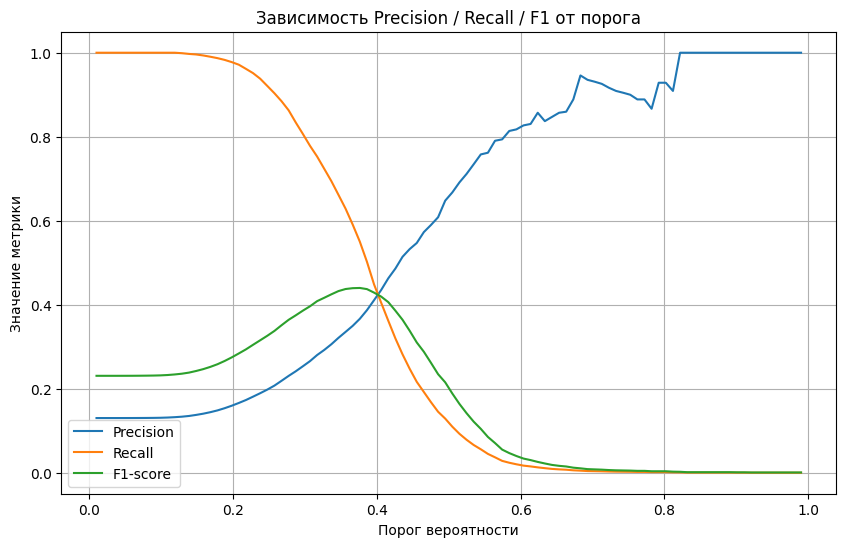

In [49]:
model.eval()
with torch.no_grad():
    val_logits = model(tensors['val']['x_float'], tensors['val']['x_cat'])
    val_proba = torch.sigmoid(val_logits).cpu().numpy()
    val_true = tensors['val']['y'].cpu().numpy()

plot_precision_recall_curve(val_true, val_proba)

###### Считаю наилучшим трешхолдом =0.48 , тк важнее немного пожертвовать precision, чтобы вырос recall, и при этом доля false positive решений не была заоблачной

### === Оценка качества на тесте с подходящим трешхолдом ===

In [50]:
evaluate_on_test(model, tensors, threshold=0.48)


Финальные метрики на тесте при threshold = 0.48:
Precision: 0.6220
Recall:    0.1753
ROC AUC:   0.8082
Confusion Matrix:
 [[51247   843]
 [ 6523  1387]]


In [51]:
model.eval()
with torch.no_grad():
    test_proba = torch.sigmoid(model(tensors['test']['x_float'], tensors['test']['x_cat'])).cpu().numpy()
y_true = tensors['test']['y'].cpu().numpy()

In [52]:
print(f"Flow cut with best threshold: {flow_cut(test_proba, 0.48):.4f}")

Flow cut with best threshold: 0.0372


##### Метрики,если срез в 4%

In [53]:
threshold_4pct = get_threshold_for_top_percent(test_proba, top_percent=0.04)
y_pred_top4 = (test_proba >= threshold_4pct).astype(int)

#метрики в этом срезе:
precision = precision_score(y_true, y_pred_top4)
recall = recall_score(y_true, y_pred_top4)
stream_cut = (y_pred_top4 == 1).mean()

print(f"Threshold @ top 4%: {threshold_4pct:.4f}")
print(f"Precision@4%: {precision:.4f}")
print(f"Recall@4%:    {recall:.4f}")
print(f"Отсечено:     {stream_cut*100:.2f}% заявок")

Threshold @ top 4%: 0.4756
Precision@4%: 0.6071
Recall@4%:    0.1842
Отсечено:     4.00% заявок


### === Важность фичей ===

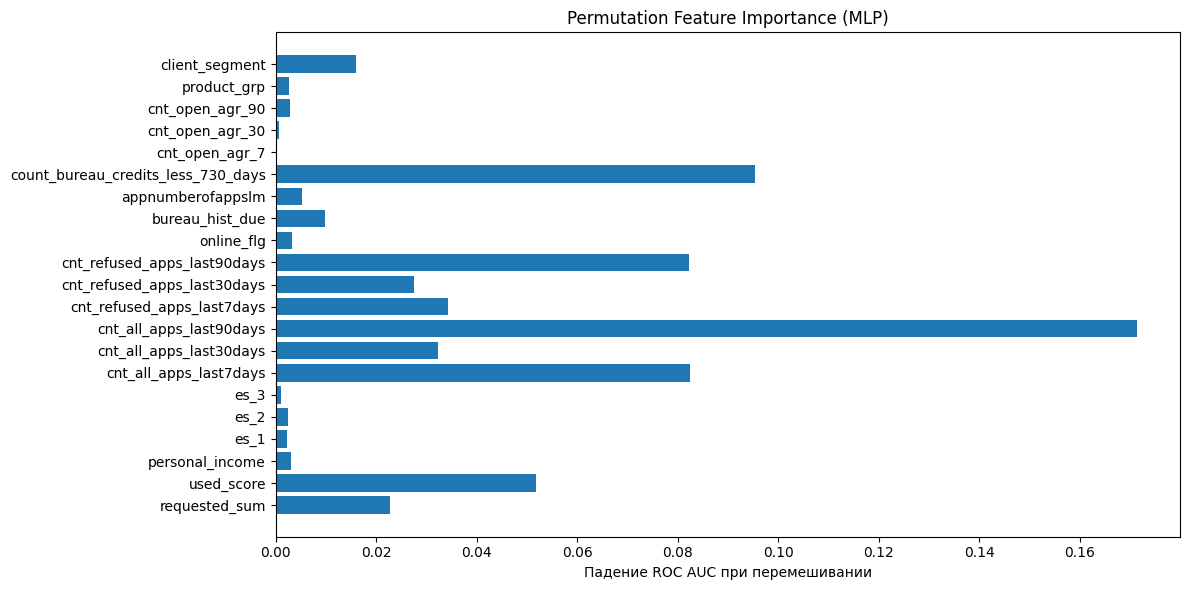

In [58]:
X_cat_df = X.select_dtypes(include=['object'])
X_float_df = X.select_dtypes(include=['float'])
X_int_float_df = X.select_dtypes(include=['int64']).astype(np.float32)
X_float_df = pd.concat([X_float_df, X_int_float_df], axis=1)

feature_names = {
    'float': list(X_float_df.columns),
    'cat': list(X_cat_df.columns),
}

importances, names = permutation_importance(model, tensors, feature_names=feature_names)

plt.figure(figsize=(12, 6))
plt.barh(names, importances)
plt.title("Permutation Feature Importance (MLP)")
plt.xlabel("Падение ROC AUC при перемешивании")
plt.tight_layout()
plt.show()